In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pynq import allocate, Overlay
from pathlib import Path

In [2]:
rgb2gray_design = Overlay("rgb2gray.bit")

In [3]:
for i in rgb2gray_design.ip_dict:
    print(i)

cvtcolor_rgb2gray_0
axi_dma_0
processing_system7_0


In [4]:
dma = rgb2gray_design.axi_dma_0
rgb2gray = rgb2gray_design.cvtcolor_rgb2gray_0

In [6]:
import sys
print(sys.path[0])
image_path = "/home/xilinx/jupyter_notebooks/images/Emir_Abdelkader_4K.jpg"
original_image = Image.open(image_path)

/home/xilinx/jupyter_notebooks/rgb2gray


Image size: 3840x2160 pixels.


<Figure size 864x576 with 0 Axes>

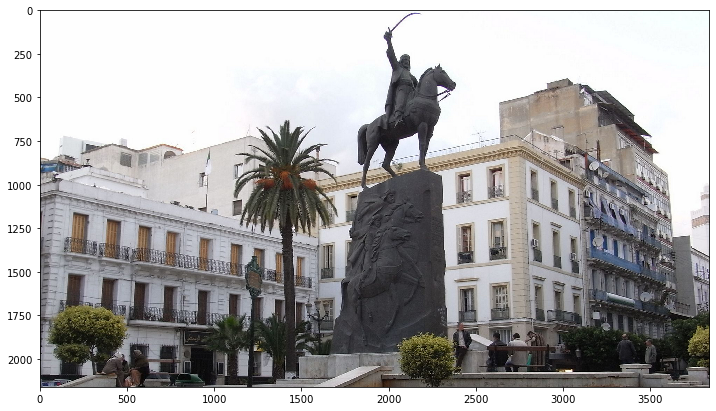

In [7]:
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)

width, height = original_image.size
print("Image size: {}x{} pixels.".format(width, height))
plt.figure(figsize=(12, 10));
_ = plt.imshow(original_image)

In [8]:
in_buffer = allocate(shape=(height, width, 3), 
                           dtype=np.uint8, cacheable=1)
out_buffer = allocate(shape=(height, width), 
                           dtype=np.uint8, cacheable=1)

In [9]:
in_buffer[:] = np.array(original_image)

In [10]:
def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    rgb2gray.write(0x00,0x81) # start.      0x0 is DDR memory address
    dma.sendchannel.wait()
    dma.recvchannel.wait()

In [11]:
rgb2gray.register_map.src_rows = height
rgb2gray.register_map.src_cols = width

In [12]:
run_kernel()
gray_image = Image.fromarray(out_buffer)

Image size: 3840x2160 pixels.


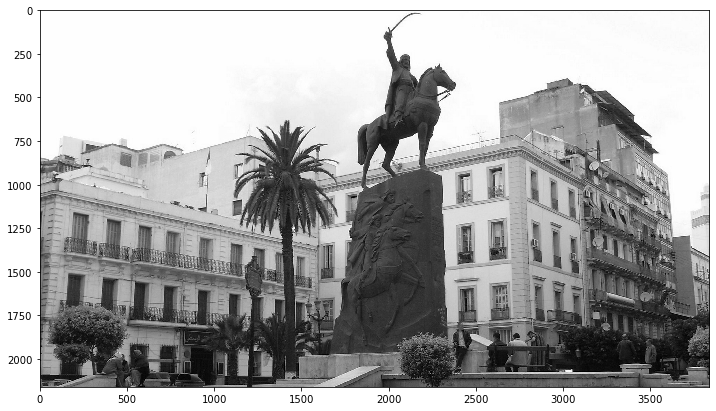

In [13]:
print("Image size: {}x{} pixels.".format(width, height))
plt.figure(figsize=(12, 10));
_ = plt.imshow(gray_image,cmap='gray', vmin=0, vmax=255)

In [15]:
gray_image.save('Emir_Abdelkader_4K_gray.png')

In [29]:
%%timeit
run_kernel()
gray_image = Image.fromarray(out_buffer)

148 ms ± 275 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
del in_buffer
del out_buffer

Image size: 3840x2160 pixels.


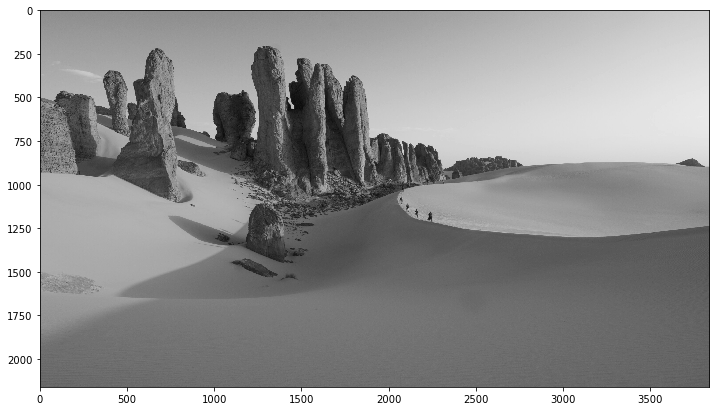

In [31]:
from PIL import Image, ImageOps
gray_image_sw = ImageOps.grayscale(original_image)
print("Image size: {}x{} pixels.".format(width, height))
plt.figure(figsize=(12, 10));
_ = plt.imshow(gray_image_sw,cmap='gray', vmin=0, vmax=255)

In [32]:
%%timeit
gray_image_sw = ImageOps.grayscale(original_image)

244 ms ± 263 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
